In [172]:
from datetime import datetime

import numpy as np
import pandas as pd
import statsmodels.api as sm

import utils

%matplotlib inline
import matplotlib.pyplot as plt

In [173]:
DATA_DIR = 'data/raw/06-23/'
bids = np.load(DATA_DIR + 'bid-record.npy')
asks = np.load(DATA_DIR + 'ask-record.npy')
times = np.array(list(map(np.datetime64, map(datetime.fromtimestamp, np.load(DATA_DIR + 'time-record.npy')))))
print(bids.shape)

(200000, 256, 2)


In [174]:
def construct_df(agg_sz=1, roll_mean_window_size=20):
    """agg_sz is in USD
    roll_mean_window_size is integer size for window"""

    agg_bid_vol = utils.get_aggregate_volume(bids, is_bid=True, agg_sz=agg_sz)
    agg_ask_vol = utils.get_aggregate_volume(asks, is_bid=False, agg_sz=agg_sz)
    agg_oir = (agg_bid_vol - agg_ask_vol) / (agg_bid_vol + agg_ask_vol)

    df = pd.DataFrame(data={'bid': bids[:, -1, 0],
                            'ask': asks[:, 0, 0],
                            'bid-volume': agg_bid_vol,
                            'ask-volume': agg_ask_vol,
                            'mid': (bids[:, -1, 0] + asks[:, 0, 0]) / 2,
                            'oir': agg_oir,
                            'time': times})

    df['dmid'] = df['mid'] - df['mid'].shift(1)
    df['oi'] = utils.get_oi(df)

    df['roll-mid'] = df['mid'].rolling(roll_mean_window_size).mean()
    
    return df

def gen_graphs(df):
    plt.figure(figsize=(30,20))

    height = 4

    plt.subplot(height, 2, 1)
    plt.plot(df['dmid'][0:1000]), plt.title('dmid')
    plt.subplot(height, 2, 2)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['dmid'].autocorr(lag=lag) for lag in lags]), plt.title('dmid-autocorr')

    plt.subplot(height, 2, 3)
    plt.plot(df['oir'][0:1000]), plt.title('oir')
    plt.subplot(height, 2, 4)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oir'].autocorr(lag=lag) for lag in lags]), plt.title('oir-autocorr')

    plt.subplot(height, 2, 5)
    plt.plot(df['oi'][0:300]), plt.title('oi')
    plt.subplot(height, 2, 6)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oi'].autocorr(lag=lag) for lag in lags]), plt.title('oi-autocorr')

    plt.subplot(height, 2, 7)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oi'].corr(df['dmid'].shift(lag)) for lag in lags]), plt.title('oi-dmid-corr')
    plt.subplot(height, 2, 8)
    lags = np.arange(30) + 1
    plt.bar(lags, [df['oir'].corr(df['dmid'].shift(lag)) for lag in lags]), plt.title('voi-dmid-corr')

CPU times: user 1.61 s, sys: 1.09 s, total: 2.7 s
Wall time: 2.87 s


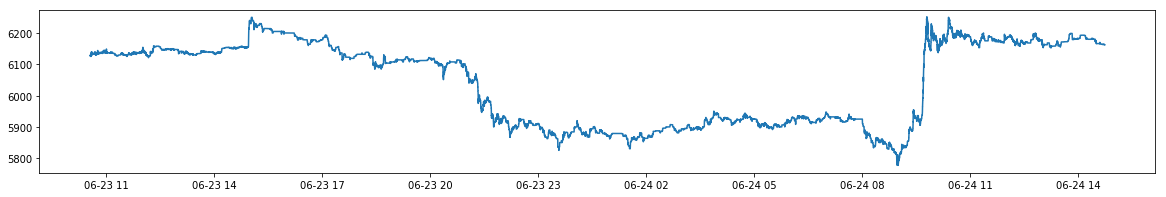

In [175]:
%%time
# construct_df(1, 20).to_pickle('data/dfs/06-19.pkl')
plt.figure(figsize=(20,3))
plt.plot_date(times, construct_df(agg_sz=1, roll_mean_window_size=20)['mid'], fmt='-')

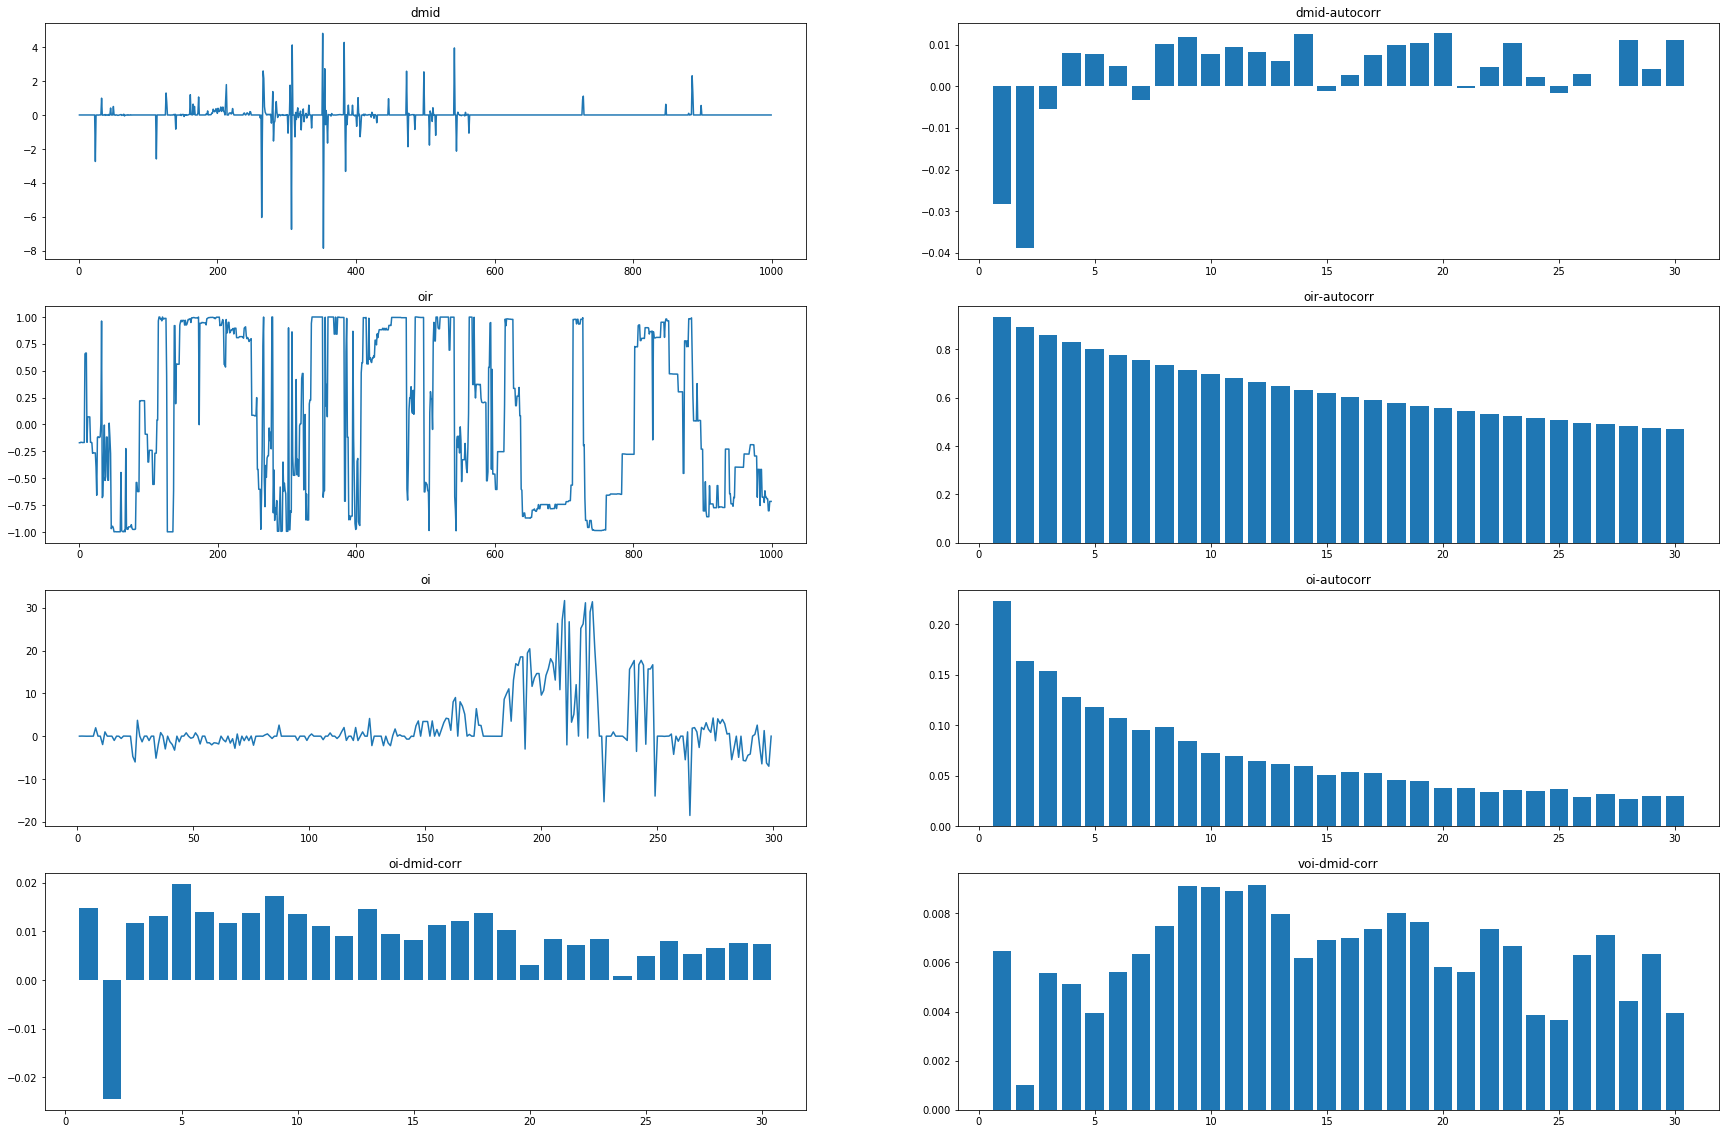

In [176]:
gen_graphs(construct_df(agg_sz=1, roll_mean_window_size=20))

In [177]:
def fit(agg_sz=1, roll_mean_window_size=20, oi_features=5, df = None):
    """oi_features: how many timesteps back do we use OI"""

    if df is None:
        df = construct_df(agg_sz=agg_sz, roll_mean_window_size=roll_mean_window_size)
    
    y = df['roll-mid'].shift(-roll_mean_window_size) - df['mid']
    y = y.round(decimals=8) # make things close to zero (floating point error) actually zero

    X = np.zeros((df.shape[0], oi_features))
    for i in range(oi_features):
        X[:, i] = df['oi'].shift(i).values

    model = sm.OLS(y, sm.add_constant(X), missing = 'drop')
    results = model.fit()
    return results

fit().rsquared_adj

0.037977119452297536

In [178]:
%%time
rsquared_adj = []
best_rsquared_adj = 0.0
for agg_sz in [0.5, 1, 2, 3, 4, 5]:
    for roll_mean_window_size in [10, 20, 30]:
        for oi_features in [3, 4, 5, 6, 7, 8, 9, 10]:
            model = fit(agg_sz=agg_sz,
                        roll_mean_window_size=roll_mean_window_size,
                        oi_features=oi_features)
            rsquared_adj.append((model.rsquared_adj, agg_sz, roll_mean_window_size, oi_features))
            if model.rsquared_adj > best_rsquared_adj:
                best_rsquared_adj = model.rsquared_adj
                print(model.rsquared_adj, agg_sz, roll_mean_window_size, oi_features)

0.02648311992797936 0.5 10 3
0.028644452230908612 0.5 10 4
0.030087076692013714 0.5 10 5
0.031240798353563415 0.5 10 6
0.03219512952487047 0.5 10 7
0.03297149354212969 0.5 10 8
0.03355587920543024 0.5 10 9
0.03388081445627833 0.5 10 10
0.0348398944667343 0.5 20 4
0.03719369783671378 0.5 20 5
0.03908374607965548 0.5 20 6
0.04065170313047328 0.5 20 7
0.04194435382068862 0.5 20 8
0.042954840232143354 0.5 20 9
0.04364654718523242 0.5 20 10
0.04483990833792584 0.5 30 8
0.04599036384462907 0.5 30 9
0.04680999361412963 0.5 30 10
CPU times: user 3min 28s, sys: 2min 36s, total: 6min 4s
Wall time: 6min 4s


In [179]:
rsquared_adj.sort()
for row in rsquared_adj[:-10:-1]:
    print(row)

(0.04680999361412963, 0.5, 30, 10)
(0.04637905345437743, 1, 30, 10)
(0.04599036384462907, 0.5, 30, 9)
(0.04577218545761352, 2, 30, 10)
(0.04567807732229301, 1, 30, 9)
(0.045143741218559574, 2, 30, 9)
(0.04483990833792584, 0.5, 30, 8)
(0.04478760156142858, 1, 30, 8)
(0.04449681283030982, 3, 30, 10)


In [221]:
def predict(model, df, oi_features):
    X = np.zeros((df.shape[0], oi_features))
    for i in range(oi_features):
        X[:, i] = df['oi'].shift(i).values
    return model.predict(sm.add_constant(X))

def backtest(agg_sz=1,
             roll_mean_window_size=20,
             oi_features=5,
             initial_position=0,
             taker_fee=3e-3,
             train_frac=0.5,
             trade_thresh=0.2):
    """
    train_frac: What percentage of the data (taken as prefix) should be used for train.
                The remainder is used for test.
    trade_thresh: What our linear model needs to produce in order for us to update our position. positive.
    taker_fee: percentage, default is given in https://docs.gdax.com/#trading-fees
    """

    df = construct_df(agg_sz=agg_sz, roll_mean_window_size=roll_mean_window_size)
    
    train_sz = round(df.shape[0] * train_frac)    
    train_df = df[0:train_sz]
    test_df = df[train_sz:]
    
    model = fit(agg_sz=agg_sz,
                roll_mean_window_size=roll_mean_window_size,
                oi_features=oi_features,
                df=df)
    
    preds = pd.Series(predict(model, test_df, oi_features))
    
    bull_times = preds > trade_thresh
    bear_times = preds < -trade_thresh
    bear_times *= 1 - bull_times # due to NaNs, we want to enforce that we never have both a buy and sell
    
    # This series of operations turns
    #    [     1, 1, 1, -1, 0, 0, 1, 0, 0, -1, 0]
    # -> [NaN, 1, 1, 1,  0, 0, 0, 1, 1, 1,  0, 0]
    portfolio = bull_times - bear_times
    portfolio[portfolio == 0] = np.nan
    portfolio[0] = initial_position
    portfolio = portfolio.ffill()
    portfolio *= portfolio > 0
    portfolio = portfolio.shift(1) # our position only changes after the timestep
    
    buy_times = (portfolio < portfolio.shift(-1))
    sell_times = (portfolio > portfolio.shift(-1))
    bid_prices = pd.Series(test_df['bid'].values)
    ask_prices = pd.Series(test_df['ask'].values)
    taker_fees = taker_fee * (buy_times * ask_prices + sell_times * bid_prices)
    taker_fees = taker_fees.shift(1) # the fee is accrued between timesteps and is counted towards the next timestep
    
    returns = pd.Series(test_df['dmid'].values)
    portfolio_returns = portfolio * returns
    
    times = pd.Series(test_df['time'].values)
    
    # returns are returns on bitcoin
    # portfolio returns are returns on portfolio without taker fees
    # taker fees are the fees associated with trading (always positive)
    return returns, portfolio_returns, taker_fees, times

def get_sharpe_ratio(returns, portfolio_returns):
    sr = (portfolio_returns - returns).mean() / (portfolio_returns - returns).std()
    return sr

Sharpe Ratio: -0.0056532133273262
Earnings: 42.548979999999744
CPU times: user 4.45 s, sys: 1.32 s, total: 5.76 s
Wall time: 5.73 s


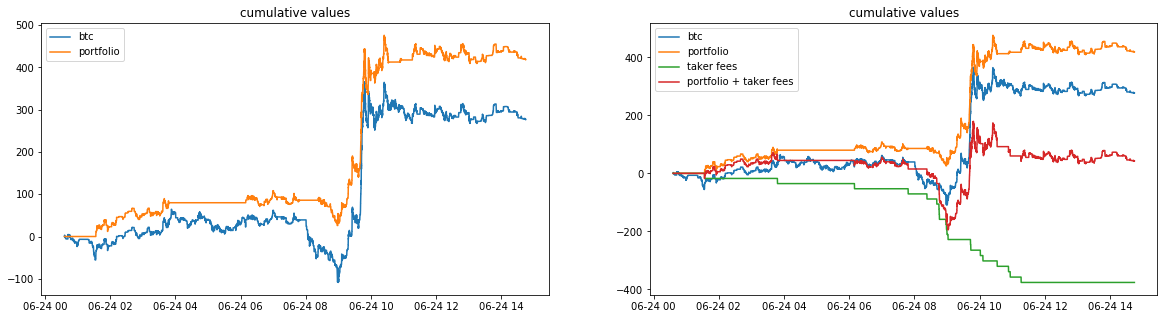

In [254]:
%%time
r, pr, tf, t = backtest(agg_sz=0.1,
                        roll_mean_window_size=20,
                        oi_features=10,
                        taker_fee=3e-3,
                        initial_position=0,
                        trade_thresh=1.98)
print("Sharpe Ratio:", get_sharpe_ratio(r, pr - tf))
print("Earnings:", pr.sum() - tf.sum())

plt.figure(figsize=(20,5))

plt.subplot(1, 2, 1)
plt.plot_date(t, r.cumsum(), label='btc', fmt='-')
plt.plot_date(t, pr.cumsum(), label='portfolio', fmt='-')
plt.title('cumulative values')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot_date(t, r.cumsum(), label='btc', fmt='-')
plt.plot_date(t, pr.cumsum(), label='portfolio', fmt='-')
plt.plot_date(t, -tf.cumsum(), label='taker fees', fmt='-')
plt.plot_date(t, pr.cumsum() - tf.cumsum(), label='portfolio + taker fees', fmt='-')
plt.title('cumulative values')
plt.legend()